In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.optimize import linear_sum_assignment
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
# Load data
loaded_df = pd.read_hdf('../data/sample_otu_arrays.h5', key='df')

# Set random seed
np.random.seed(42)

# Split indices into train/test
train_idx, test_idx = train_test_split(loaded_df.index, test_size=0.2, random_state=42)

# Create train and test dataframes
train_df = loaded_df.loc[train_idx]
test_df = loaded_df.loc[test_idx]

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")
print("\nFirst few training samples:")
print(train_df.head())

# Let's also look at array lengths
array_lengths = [len(x) for x in loaded_df['otu_arrays']]
print(f"\nMin array length: {min(array_lengths)}")
print(f"Max array length: {max(array_lengths)}")
print(f"Mean array length: {np.mean(array_lengths):.2f}")

Train size: 6486
Test size: 1622

First few training samples:
                                                            otu_arrays
Unnamed: 0                                                            
SRR044975.SRS011167  [30, 58, 82, 89, 93, 98, 99, 104, 117, 120, 12...
SRR049604.SRS049164  [9, 10, 11, 14, 15, 16, 17, 20, 28, 30, 31, 32...
SRR331714.SRS076947  [19, 30, 43, 58, 65, 70, 71, 74, 80, 90, 92, 9...
SRR089999.SRS077685  [12, 14, 18, 20, 22, 38, 45, 67, 68, 76, 88, 1...
SRR048091.SRS021563  [19, 30, 45, 52, 58, 60, 65, 70, 74, 80, 90, 9...

Min array length: 3
Max array length: 277
Mean array length: 69.10


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

class OTUDataset(Dataset):
    def __init__(self, df, pad_token_id=0):
        self.df = df
        self.pad_token_id = pad_token_id
        
        # Find max sequence length for padding
        self.max_len = max(len(x) for x in df['otu_arrays'])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        array = self.df.iloc[idx]['otu_arrays']
        
        # Create padded sequence
        padded = torch.full((self.max_len,), self.pad_token_id, dtype=torch.long)
        padded[:len(array)] = torch.tensor(array, dtype=torch.long)
        
        # Create padding mask (True/1 for real tokens, False/0 for padding)
        # to match model's convention. model internally inverts to match pytorch transformer expectation.
        padding_mask = torch.ones(self.max_len, dtype=torch.bool)
        padding_mask[len(array):] = False
        
        return {
            'input_ids': padded,
            'padding_mask': padding_mask,
            'seq_len': len(array)
        }

# Create datasets
train_dataset = OTUDataset(train_df, pad_token_id=0)
test_dataset = OTUDataset(test_df, pad_token_id=0)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify shapes
for i in train_loader:
   print(i['input_ids'].shape)
   print(i['padding_mask'].shape)
   print(i['seq_len'])
   break

# Get vocab size (maximum token ID + 1 for padding)
vocab_size = max(max(x) for x in loaded_df['otu_arrays']) + 1
print(f"\nVocabulary size: {vocab_size}")

torch.Size([32, 277])
torch.Size([32, 277])
tensor([ 66,  33,  29,  51,  45,  56, 125,  86,  24,  19,  21,  49,  47,  17,
         80,  50,  75,  71,  80,  36,  50,  82,  79,  20,  92,  44,  82,  29,
        117,  22, 108,  67])

Vocabulary size: 519


In [4]:
import importlib
import model_arch
import scheduler
importlib.reload(model_arch)
importlib.reload(scheduler)

from model_arch import simplifiedV2
from scheduler import AdaptiveSchedule

In [5]:
def train_step(model, batch, scheduler, optimizer):

    # Get batch data
    input_ids = batch['input_ids']
    padding_mask = batch['padding_mask']
    batch_size, seq_len = input_ids.shape
    
    # Sample random timesteps for training
    timesteps = scheduler.sample((batch_size,)).to(input_ids.device)  # Shape: [batch_size]
   
    
    # Forward pass through model
    logits = model(
        input_ids,
        t=timesteps,
        padding_mask=padding_mask
    )
    
    # Calculate cross entropy loss (ignoring padding)
    loss_fn = nn.CrossEntropyLoss(ignore_index=0)  # Assuming 0 is pad_token_id
    loss = loss_fn(
        logits.view(-1, logits.size(-1)),
        input_ids.view(-1)
    )
    

    # Calculate entropy for scheduler
    with torch.no_grad():
        probs = F.softmax(logits, dim=-1)
        
        # Add small epsilon to prevent log(0)
        eps = 1e-8
        probs = torch.clamp(probs, min=eps, max=1-eps)
        
        entropy = -(probs * torch.log(probs)).sum(dim=-1)  # [batch_size, seq_len]
        
        # Expand timesteps to match sequence dimension
        timesteps_expanded = timesteps.unsqueeze(-1).expand(-1, seq_len)
        
        # Add entropy data to scheduler (excluding padding)
        scheduler.add_data(
            entropy[padding_mask],
            timesteps_expanded[padding_mask]
        )

    # Backprop with gradient clipping
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    
    return loss.item(), entropy.mean().item()


def eval_step(model, batch):
    """Single evaluation step for CDCD model
    
    Args:
        model: CDCDModel instance
        batch: Dictionary containing input_ids and padding_mask
        
    Returns:
        loss: scalar evaluation loss
        entropy: entropy statistics
    """
    # Get batch data
    input_ids = batch['input_ids']
    padding_mask = batch['padding_mask']
    batch_size, seq_len = input_ids.shape
    
    # Use middle timestep for evaluation (or could sample uniformly)
    timesteps = scheduler.sample((batch_size,)).to(input_ids.device)
    
    # Forward pass through model
    logits = model(
        input_ids,
        t=timesteps,
        padding_mask=padding_mask
    )
    
    
    # Calculate cross entropy loss (ignoring padding)
    loss_fn = nn.CrossEntropyLoss(ignore_index=0)
    loss = loss_fn(
        logits.view(-1, logits.size(-1)),
        input_ids.view(-1)
    )
    
    # Calculate entropy
    probs = F.softmax(logits, dim=-1)
    eps = 1e-8
    probs = torch.clamp(probs, min=eps, max=1-eps)
    entropy = -(probs * torch.log(probs)).sum(dim=-1)
    
    return loss.item(), entropy.mean().item()

In [6]:
def run_epoch(model, dataloader, scheduler, optimizer, train_run=True, epoch_num=None):
    """Runs one epoch of training or evaluation for the CDCD model"""
    model.train() if train_run else model.eval()
    total_loss = 0
    total_entropy = 0
    num_batches = 0
    
    # Setup progress bar
    mode = "Train" if train_run else "Eval"
    epoch_str = f"Epoch {epoch_num}" if epoch_num is not None else mode
    pbar = tqdm(total=len(dataloader), desc=f"{epoch_str} Loss: 0.0000, Entropy: 0.0000")
    device = next(model.parameters()).device

    # Main loop
    for batch in dataloader:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        if train_run:
            loss, entropy = train_step(model, batch, scheduler, optimizer)
        else:
            # Use separate eval step without optimizer/scheduler
            loss, entropy = eval_step(model, batch)
        
        # Accumulate metrics
        total_loss += loss
        total_entropy += entropy
        num_batches += 1
        
        # Update progress bar
        avg_loss = total_loss / num_batches
        avg_entropy = total_entropy / num_batches
        pbar.set_description(f"{epoch_str} Loss: {avg_loss:.4f}, Entropy: {avg_entropy:.4f}")
        pbar.update(1)
    
    pbar.close()
    
    # Calculate final averages
    avg_loss = total_loss / num_batches
    avg_entropy = total_entropy / num_batches
    
    # Update scheduler parameters if training
    if train_run:
        scheduler.update_optimal_parameters(history=10_000)
    
    return {
        "loss": avg_loss,
        "entropy": avg_entropy,
        "num_batches": num_batches
    }

In [7]:
def train(
    model,
    train_dataloader,
    eval_dataloader,
    noise_scheduler,
    num_epochs,
    initial_lr=1e-4,
    min_lr=1e-6,
    first_cycle_epochs=30,
    cycle_mult=2,
    eval_every=1,
    early_stopping_patience=5,
    save_dir="checkpoints",
    device="cuda",
):
    """Trains the CDCD model using Cosine Annealing with Warm Restarts
    
    Args:
        model: CDCDModel instance
        train_dataloader: DataLoader for training data
        eval_dataloader: DataLoader for evaluation data
        noise_scheduler: Noise scheduler for diffusion process
        num_epochs: Number of epochs to train for
        initial_lr: Initial learning rate
        min_lr: Minimum learning rate
        first_cycle_epochs: Length of first cosine cycle
        cycle_mult: Factor to multiply cycle length by after each restart
        eval_every: Number of epochs between evaluation runs
        early_stopping_patience: Number of epochs to wait for improvement before stopping
        save_dir: Directory to save model checkpoints
        device: Device to train on
    """
    import torch
    from torch.optim import lr_scheduler
    from pathlib import Path
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=initial_lr)
    lr_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=first_cycle_epochs,
        T_mult=cycle_mult,
        eta_min=min_lr
    )
    
    best_eval_loss = float('inf')
    best_epoch = 0
    epochs_without_improvement = 0
    train_losses = []
    eval_losses = []
    learning_rates = []
    
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    model = model.to(device)
    
    for epoch in range(num_epochs):
        current_lr = optimizer.param_groups[0]['lr']
        print(f"\nEpoch {epoch+1}/{num_epochs} - Learning Rate: {current_lr:.6f}")
        
        # Training phase
        train_metrics = run_epoch(
            model=model,
            dataloader=train_dataloader,
            scheduler=noise_scheduler,
            optimizer=optimizer,
            train_run=True,
            epoch_num=epoch+1
        )
        train_losses.append(train_metrics['loss'])
        
        # Evaluation phase
        if (epoch + 1) % eval_every == 0:
            eval_metrics = run_epoch(
                model=model,
                dataloader=eval_dataloader,
                scheduler=noise_scheduler,
                optimizer=optimizer,
                train_run=False,
                epoch_num=epoch+1
            )
            eval_losses.append(eval_metrics['loss'])
            
            # Save best model and handle early stopping
            if eval_metrics['loss'] < best_eval_loss:
                best_eval_loss = eval_metrics['loss']
                best_epoch = epoch
                epochs_without_improvement = 0
                
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': lr_scheduler.state_dict(),
                    'noise_scheduler_state': noise_scheduler.state_dict(),
                    'loss': best_eval_loss,
                }, save_dir / 'best_model.pt')
            else:
                epochs_without_improvement += 1
            print('-'*16)
            print(f"Eval Loss: {eval_metrics['loss']:.4f}")
            print(f"Best Loss: {best_eval_loss:.4f} (Epoch {best_epoch+1})")
            
            if epochs_without_improvement >= early_stopping_patience:
                print(f"\nEarly stopping triggered after {epoch+1} epochs")
                break
        
        # Update learning rate
        lr_scheduler.step()
        learning_rates.append(current_lr)
        
        # Save periodic checkpoint
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': lr_scheduler.state_dict(),
                'noise_scheduler_state': noise_scheduler.state_dict(),
                'loss': train_metrics['loss'],
            }, save_dir / f'checkpoint_epoch_{epoch+1}.pt')
    
    # Load best model
    best_checkpoint = torch.load(save_dir / 'best_model.pt')
    model.load_state_dict(best_checkpoint['model_state_dict'])
    
    return {
        'train_losses': train_losses,
        'eval_losses': eval_losses,
        'best_epoch': best_epoch,
        'learning_rates': learning_rates
    }

In [8]:
# Model hyperparameters
hidden_dim = 32  # Dimension of hidden layers
embedding_dim = 32  # Dimension of embeddings
transformer_dim = embedding_dim
num_heads = 16  # Number of attention heads
num_layers = 4  # Number of transformer layers
t_min = 1 # Minimum time value
t_max = 25  # To high breaks scheduler. This value really depends on embed dim: SNR = ed/t^2. if ed = 32, tmax=25 ~ 0 SNR
vocab_size = 519
embedding_scale=0.1

model = simplifiedV2(
    hidden_dim = hidden_dim,
    embedding_dim = embedding_dim,
    num_heads = num_heads,
    transformer_dim=transformer_dim,
    num_layers = num_layers,
    vocab_size = vocab_size,
    dropout=0.1,
    embedding_scale=embedding_scale
)

scheduler = AdaptiveSchedule(
    tmin = t_min,
    tmax = t_max,
    mu = 12.5,
    sigma = 8,
    height = 1,
    offset = 0.1
)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [10]:


for batch in train_loader:
# Move batch to device
    batch = {k: v.to(device) for k, v in batch.items()}
    train_step(model,batch, scheduler, optimizer)
    break

In [18]:
training_history = train(
    model=model,
    train_dataloader=train_loader,
    eval_dataloader=test_loader,
    noise_scheduler=scheduler,
    num_epochs=60,
    initial_lr=1e-3,
    min_lr=1e-8,
    first_cycle_epochs=8,  # Length of first cosine cycle
    cycle_mult=2,  # Each subsequent cycle is twice as long
    eval_every=1,
    early_stopping_patience=20,
    save_dir="checkpoints"
)


Epoch 1/60 - Learning Rate: 0.001000


Epoch 1 Loss: 3.1094, Entropy: 3.6621: 100%|██████████| 203/203 [00:05<00:00, 37.38it/s]
2025-02-20 14:38:47,005 - INFO - Updated optimal parameters: mu=1.9749918753714433, sigma=1.116091073331054, height=7.0418747572384985, offset=-1.2463449747440192


[1.9749918753714433, 1.116091073331054, 7.0418747572384985, -1.2463449747440192]


Epoch 1 Loss: 3.1223, Entropy: 3.6003: 100%|██████████| 51/51 [00:00<00:00, 126.64it/s]


----------------
Eval Loss: 3.1223
Best Loss: 3.1223 (Epoch 1)

Epoch 2/60 - Learning Rate: 0.000962


Epoch 2 Loss: 3.0606, Entropy: 3.6094: 100%|██████████| 203/203 [00:05<00:00, 38.27it/s]
2025-02-20 14:38:52,782 - INFO - Updated optimal parameters: mu=1.9740397471868902, sigma=1.072614942291447, height=6.886769060071004, offset=-1.152962264781055


[1.9740397471868902, 1.072614942291447, 6.886769060071004, -1.152962264781055]


Epoch 2 Loss: 3.0354, Entropy: 3.4951: 100%|██████████| 51/51 [00:00<00:00, 125.75it/s]


----------------
Eval Loss: 3.0354
Best Loss: 3.0354 (Epoch 2)

Epoch 3/60 - Learning Rate: 0.000854


Epoch 3 Loss: 3.0548, Entropy: 3.6003: 100%|██████████| 203/203 [00:05<00:00, 38.22it/s]
2025-02-20 14:38:58,533 - INFO - Updated optimal parameters: mu=2.0046514428041045, sigma=1.0567457914899978, height=6.895464469261197, offset=-1.0910900792793243


[2.0046514428041045, 1.0567457914899978, 6.895464469261197, -1.0910900792793243]


Epoch 3 Loss: 3.0921, Entropy: 3.4578: 100%|██████████| 51/51 [00:00<00:00, 126.54it/s]


----------------
Eval Loss: 3.0921
Best Loss: 3.0354 (Epoch 2)

Epoch 4/60 - Learning Rate: 0.000691


Epoch 4 Loss: 3.0559, Entropy: 3.5795: 100%|██████████| 203/203 [00:05<00:00, 38.20it/s]
2025-02-20 14:39:04,267 - INFO - Updated optimal parameters: mu=2.0341872050008183, sigma=1.017411741360015, height=6.746191927610252, offset=-1.0648059506026342


[2.0341872050008183, 1.017411741360015, 6.746191927610252, -1.0648059506026342]


Epoch 4 Loss: 2.9470, Entropy: 3.3837: 100%|██████████| 51/51 [00:00<00:00, 126.30it/s]


----------------
Eval Loss: 2.9470
Best Loss: 2.9470 (Epoch 4)

Epoch 5/60 - Learning Rate: 0.000500


Epoch 5 Loss: 3.0653, Entropy: 3.6002: 100%|██████████| 203/203 [00:05<00:00, 38.27it/s]
2025-02-20 14:39:10,046 - INFO - Updated optimal parameters: mu=2.020358309949296, sigma=1.0020097201643017, height=6.575304827130198, offset=-0.9958960665913366


[2.020358309949296, 1.0020097201643017, 6.575304827130198, -0.9958960665913366]


Epoch 5 Loss: 3.0067, Entropy: 3.4892: 100%|██████████| 51/51 [00:00<00:00, 126.79it/s]


----------------
Eval Loss: 3.0067
Best Loss: 2.9470 (Epoch 4)

Epoch 6/60 - Learning Rate: 0.000309


Epoch 6 Loss: 3.0428, Entropy: 3.5740: 100%|██████████| 203/203 [00:05<00:00, 38.28it/s]
2025-02-20 14:39:15,767 - INFO - Updated optimal parameters: mu=2.0245284920178976, sigma=0.9312345144905517, height=6.531974115153867, offset=-0.9636258463144421


[2.0245284920178976, 0.9312345144905517, 6.531974115153867, -0.9636258463144421]


Epoch 6 Loss: 2.9488, Entropy: 3.4733: 100%|██████████| 51/51 [00:00<00:00, 126.96it/s]


----------------
Eval Loss: 2.9488
Best Loss: 2.9470 (Epoch 4)

Epoch 7/60 - Learning Rate: 0.000146


Epoch 7 Loss: 2.9645, Entropy: 3.5074: 100%|██████████| 203/203 [00:05<00:00, 39.27it/s]
2025-02-20 14:39:21,354 - INFO - Updated optimal parameters: mu=2.078088602932915, sigma=1.0493143024757559, height=6.543558300509187, offset=-0.8963790047366317


[2.078088602932915, 1.0493143024757559, 6.543558300509187, -0.8963790047366317]


Epoch 7 Loss: 3.0764, Entropy: 3.5431: 100%|██████████| 51/51 [00:00<00:00, 127.11it/s]


----------------
Eval Loss: 3.0764
Best Loss: 2.9470 (Epoch 4)

Epoch 8/60 - Learning Rate: 0.000038


Epoch 8 Loss: 3.0761, Entropy: 3.5947: 100%|██████████| 203/203 [00:05<00:00, 38.21it/s]
2025-02-20 14:39:27,086 - INFO - Updated optimal parameters: mu=2.0445845787416927, sigma=0.9859605179897398, height=6.5898453874852185, offset=-0.9739406582484398


[2.0445845787416927, 0.9859605179897398, 6.5898453874852185, -0.9739406582484398]


Epoch 8 Loss: 3.0699, Entropy: 3.5350: 100%|██████████| 51/51 [00:00<00:00, 127.74it/s]


----------------
Eval Loss: 3.0699
Best Loss: 2.9470 (Epoch 4)

Epoch 9/60 - Learning Rate: 0.001000


Epoch 9 Loss: 3.0080, Entropy: 3.5399: 100%|██████████| 203/203 [00:05<00:00, 38.03it/s]
2025-02-20 14:39:32,840 - INFO - Updated optimal parameters: mu=2.0850119303046473, sigma=0.986404363723951, height=6.48400788607105, offset=-0.9425225463137171


[2.0850119303046473, 0.986404363723951, 6.48400788607105, -0.9425225463137171]


Epoch 9 Loss: 3.0773, Entropy: 3.5094: 100%|██████████| 51/51 [00:00<00:00, 126.77it/s]


----------------
Eval Loss: 3.0773
Best Loss: 2.9470 (Epoch 4)

Epoch 10/60 - Learning Rate: 0.000990


Epoch 10 Loss: 3.0385, Entropy: 3.5335: 100%|██████████| 203/203 [00:05<00:00, 38.09it/s]
2025-02-20 14:39:38,587 - INFO - Updated optimal parameters: mu=2.0832955238003503, sigma=0.9828081302326309, height=6.47750137335612, offset=-0.9120297151181983


[2.0832955238003503, 0.9828081302326309, 6.47750137335612, -0.9120297151181983]


Epoch 10 Loss: 3.0305, Entropy: 3.5062: 100%|██████████| 51/51 [00:00<00:00, 126.28it/s]


----------------
Eval Loss: 3.0305
Best Loss: 2.9470 (Epoch 4)

Epoch 11/60 - Learning Rate: 0.000962


Epoch 11 Loss: 3.0556, Entropy: 3.5447: 100%|██████████| 203/203 [00:05<00:00, 38.27it/s]
2025-02-20 14:39:44,334 - INFO - Updated optimal parameters: mu=2.071643031003021, sigma=0.9408950868449836, height=6.510604033385409, offset=-0.908861748418803


[2.071643031003021, 0.9408950868449836, 6.510604033385409, -0.908861748418803]


Epoch 11 Loss: 2.9050, Entropy: 3.4833: 100%|██████████| 51/51 [00:00<00:00, 127.65it/s]


----------------
Eval Loss: 2.9050
Best Loss: 2.9050 (Epoch 11)

Epoch 12/60 - Learning Rate: 0.000916


Epoch 12 Loss: 3.0354, Entropy: 3.4997: 100%|██████████| 203/203 [00:05<00:00, 38.16it/s]
2025-02-20 14:39:50,088 - INFO - Updated optimal parameters: mu=2.074998704123429, sigma=0.8923100996814768, height=6.472539677192832, offset=-0.8835075214884206


[2.074998704123429, 0.8923100996814768, 6.472539677192832, -0.8835075214884206]


Epoch 12 Loss: 2.9241, Entropy: 3.3343: 100%|██████████| 51/51 [00:00<00:00, 127.78it/s]


----------------
Eval Loss: 2.9241
Best Loss: 2.9050 (Epoch 11)

Epoch 13/60 - Learning Rate: 0.000854


Epoch 13 Loss: 2.9766, Entropy: 3.4344: 100%|██████████| 203/203 [00:05<00:00, 38.17it/s]
2025-02-20 14:39:55,824 - INFO - Updated optimal parameters: mu=2.110731842237481, sigma=0.9396157707072865, height=6.3771364214680855, offset=-0.8367238420965118


[2.110731842237481, 0.9396157707072865, 6.3771364214680855, -0.8367238420965118]


Epoch 13 Loss: 3.0177, Entropy: 3.4101: 100%|██████████| 51/51 [00:00<00:00, 126.78it/s]


----------------
Eval Loss: 3.0177
Best Loss: 2.9050 (Epoch 11)

Epoch 14/60 - Learning Rate: 0.000778


Epoch 14 Loss: 3.0779, Entropy: 3.5307: 100%|██████████| 203/203 [00:05<00:00, 38.10it/s]
2025-02-20 14:40:01,573 - INFO - Updated optimal parameters: mu=2.088295534638824, sigma=0.92405633444153, height=6.541554210107598, offset=-0.8501704075828511


[2.088295534638824, 0.92405633444153, 6.541554210107598, -0.8501704075828511]


Epoch 14 Loss: 3.0084, Entropy: 3.4664: 100%|██████████| 51/51 [00:00<00:00, 124.78it/s]


----------------
Eval Loss: 3.0084
Best Loss: 2.9050 (Epoch 11)

Epoch 15/60 - Learning Rate: 0.000691


Epoch 15 Loss: 2.9881, Entropy: 3.5025: 100%|██████████| 203/203 [00:05<00:00, 38.27it/s]
2025-02-20 14:40:07,303 - INFO - Updated optimal parameters: mu=2.0837242546611403, sigma=0.9136961250926459, height=6.4448973241369725, offset=-0.8674485656938902


[2.0837242546611403, 0.9136961250926459, 6.4448973241369725, -0.8674485656938902]


Epoch 15 Loss: 2.9829, Entropy: 3.4826: 100%|██████████| 51/51 [00:00<00:00, 121.78it/s]


----------------
Eval Loss: 2.9829
Best Loss: 2.9050 (Epoch 11)

Epoch 16/60 - Learning Rate: 0.000598


Epoch 16 Loss: 2.9754, Entropy: 3.5188: 100%|██████████| 203/203 [00:05<00:00, 38.01it/s]
2025-02-20 14:40:13,081 - INFO - Updated optimal parameters: mu=2.057009589687663, sigma=0.884026077099901, height=6.380656903329847, offset=-0.8477567740990894


[2.057009589687663, 0.884026077099901, 6.380656903329847, -0.8477567740990894]


Epoch 16 Loss: 2.8736, Entropy: 3.3567: 100%|██████████| 51/51 [00:00<00:00, 117.32it/s]


----------------
Eval Loss: 2.8736
Best Loss: 2.8736 (Epoch 16)

Epoch 17/60 - Learning Rate: 0.000500


Epoch 17 Loss: 2.9165, Entropy: 3.4580: 100%|██████████| 203/203 [00:05<00:00, 37.89it/s]
2025-02-20 14:40:18,911 - INFO - Updated optimal parameters: mu=2.081487448330423, sigma=0.9129111368526648, height=6.298673227513831, offset=-0.8243890645684573


[2.081487448330423, 0.9129111368526648, 6.298673227513831, -0.8243890645684573]


Epoch 17 Loss: 3.0061, Entropy: 3.4961: 100%|██████████| 51/51 [00:00<00:00, 116.98it/s]


----------------
Eval Loss: 3.0061
Best Loss: 2.8736 (Epoch 16)

Epoch 18/60 - Learning Rate: 0.000402


Epoch 18 Loss: 2.9796, Entropy: 3.5136: 100%|██████████| 203/203 [00:05<00:00, 37.87it/s]
2025-02-20 14:40:24,728 - INFO - Updated optimal parameters: mu=2.100483121127772, sigma=0.8804723761870386, height=6.371303878784988, offset=-0.8286807752724388


[2.100483121127772, 0.8804723761870386, 6.371303878784988, -0.8286807752724388]


Epoch 18 Loss: 2.8846, Entropy: 3.3653: 100%|██████████| 51/51 [00:00<00:00, 116.48it/s]


----------------
Eval Loss: 2.8846
Best Loss: 2.8736 (Epoch 16)

Epoch 19/60 - Learning Rate: 0.000309


Epoch 19 Loss: 2.9770, Entropy: 3.5251: 100%|██████████| 203/203 [00:05<00:00, 38.66it/s]
2025-02-20 14:40:30,434 - INFO - Updated optimal parameters: mu=2.079811188912884, sigma=0.8831975946542658, height=6.265513399284191, offset=-0.8049883233113686


[2.079811188912884, 0.8831975946542658, 6.265513399284191, -0.8049883233113686]


Epoch 19 Loss: 2.9153, Entropy: 3.4513: 100%|██████████| 51/51 [00:00<00:00, 117.13it/s]


----------------
Eval Loss: 2.9153
Best Loss: 2.8736 (Epoch 16)

Epoch 20/60 - Learning Rate: 0.000222


Epoch 20 Loss: 2.9412, Entropy: 3.5024: 100%|██████████| 203/203 [00:05<00:00, 39.03it/s]
2025-02-20 14:40:36,088 - INFO - Updated optimal parameters: mu=2.059914153362071, sigma=0.8539087479363597, height=6.288917521214268, offset=-0.800894092153042


[2.059914153362071, 0.8539087479363597, 6.288917521214268, -0.800894092153042]


Epoch 20 Loss: 2.9007, Entropy: 3.4287: 100%|██████████| 51/51 [00:00<00:00, 116.65it/s]


----------------
Eval Loss: 2.9007
Best Loss: 2.8736 (Epoch 16)

Epoch 21/60 - Learning Rate: 0.000146


Epoch 21 Loss: 2.8867, Entropy: 3.4593: 100%|██████████| 203/203 [00:05<00:00, 38.97it/s]
2025-02-20 14:40:41,771 - INFO - Updated optimal parameters: mu=2.111820253112645, sigma=0.9000112948873571, height=6.224858705254437, offset=-0.7866657095541614


[2.111820253112645, 0.9000112948873571, 6.224858705254437, -0.7866657095541614]


Epoch 21 Loss: 2.9378, Entropy: 3.4107: 100%|██████████| 51/51 [00:00<00:00, 116.90it/s]


----------------
Eval Loss: 2.9378
Best Loss: 2.8736 (Epoch 16)

Epoch 22/60 - Learning Rate: 0.000084


Epoch 22 Loss: 2.9435, Entropy: 3.5122: 100%|██████████| 203/203 [00:05<00:00, 39.11it/s]
2025-02-20 14:40:47,418 - INFO - Updated optimal parameters: mu=2.075611341378017, sigma=0.8921534714530717, height=6.263563231266666, offset=-0.7982563515000316


[2.075611341378017, 0.8921534714530717, 6.263563231266666, -0.7982563515000316]


Epoch 22 Loss: 2.8618, Entropy: 3.3960: 100%|██████████| 51/51 [00:00<00:00, 125.59it/s]


----------------
Eval Loss: 2.8618
Best Loss: 2.8618 (Epoch 22)

Epoch 23/60 - Learning Rate: 0.000038


Epoch 23 Loss: 2.9128, Entropy: 3.4912: 100%|██████████| 203/203 [00:05<00:00, 39.34it/s]
2025-02-20 14:40:53,019 - INFO - Updated optimal parameters: mu=2.117886049927882, sigma=0.8909253792124915, height=6.3555193349244945, offset=-0.8093682911967442


[2.117886049927882, 0.8909253792124915, 6.3555193349244945, -0.8093682911967442]


Epoch 23 Loss: 2.8812, Entropy: 3.4113: 100%|██████████| 51/51 [00:00<00:00, 127.75it/s]


----------------
Eval Loss: 2.8812
Best Loss: 2.8618 (Epoch 22)

Epoch 24/60 - Learning Rate: 0.000010


Epoch 24 Loss: 2.9588, Entropy: 3.5301: 100%|██████████| 203/203 [00:05<00:00, 39.35it/s]
2025-02-20 14:40:58,594 - INFO - Updated optimal parameters: mu=2.081389708501383, sigma=0.8824641227408787, height=6.288042127064603, offset=-0.8055584659518008


[2.081389708501383, 0.8824641227408787, 6.288042127064603, -0.8055584659518008]


Epoch 24 Loss: 2.9140, Entropy: 3.4321: 100%|██████████| 51/51 [00:00<00:00, 127.73it/s]


----------------
Eval Loss: 2.9140
Best Loss: 2.8618 (Epoch 22)

Epoch 25/60 - Learning Rate: 0.001000


Epoch 25 Loss: 2.9707, Entropy: 3.5167: 100%|██████████| 203/203 [00:05<00:00, 39.29it/s]
2025-02-20 14:41:04,174 - INFO - Updated optimal parameters: mu=2.08796628967302, sigma=0.8693411983332228, height=6.277651878317527, offset=-0.8026298662375373


[2.08796628967302, 0.8693411983332228, 6.277651878317527, -0.8026298662375373]


Epoch 25 Loss: 2.8808, Entropy: 3.3569: 100%|██████████| 51/51 [00:00<00:00, 126.84it/s]


----------------
Eval Loss: 2.8808
Best Loss: 2.8618 (Epoch 22)

Epoch 26/60 - Learning Rate: 0.000998


Epoch 26 Loss: 2.9005, Entropy: 3.4643: 100%|██████████| 203/203 [00:05<00:00, 39.63it/s]
2025-02-20 14:41:09,715 - INFO - Updated optimal parameters: mu=2.087264637282581, sigma=0.8009024649092185, height=6.194659799566863, offset=-0.7883610495091941


[2.087264637282581, 0.8009024649092185, 6.194659799566863, -0.7883610495091941]


Epoch 26 Loss: 2.9519, Entropy: 3.3838: 100%|██████████| 51/51 [00:00<00:00, 127.23it/s]


----------------
Eval Loss: 2.9519
Best Loss: 2.8618 (Epoch 22)

Epoch 27/60 - Learning Rate: 0.000990


Epoch 27 Loss: 2.8859, Entropy: 3.4723: 100%|██████████| 203/203 [00:05<00:00, 39.49it/s]
2025-02-20 14:41:15,272 - INFO - Updated optimal parameters: mu=2.1331486433223588, sigma=0.8996780352872621, height=6.276816915274818, offset=-0.722444051363535


[2.1331486433223588, 0.8996780352872621, 6.276816915274818, -0.722444051363535]


Epoch 27 Loss: 2.9696, Entropy: 3.6033: 100%|██████████| 51/51 [00:00<00:00, 127.66it/s]


----------------
Eval Loss: 2.9696
Best Loss: 2.8618 (Epoch 22)

Epoch 28/60 - Learning Rate: 0.000978


Epoch 28 Loss: 2.9281, Entropy: 3.5403: 100%|██████████| 203/203 [00:05<00:00, 39.35it/s]
2025-02-20 14:41:20,849 - INFO - Updated optimal parameters: mu=2.069727875473237, sigma=0.8140677672768507, height=6.262681661204293, offset=-0.7974382147241453


[2.069727875473237, 0.8140677672768507, 6.262681661204293, -0.7974382147241453]


Epoch 28 Loss: 2.9174, Entropy: 3.4716: 100%|██████████| 51/51 [00:00<00:00, 126.51it/s]


----------------
Eval Loss: 2.9174
Best Loss: 2.8618 (Epoch 22)

Epoch 29/60 - Learning Rate: 0.000962


Epoch 29 Loss: 2.8771, Entropy: 3.5427: 100%|██████████| 203/203 [00:05<00:00, 39.35it/s]
2025-02-20 14:41:26,427 - INFO - Updated optimal parameters: mu=2.1435035125690733, sigma=0.8758746962548106, height=6.208765473878633, offset=-0.7470253418821156


[2.1435035125690733, 0.8758746962548106, 6.208765473878633, -0.7470253418821156]


Epoch 29 Loss: 3.0565, Entropy: 3.5822: 100%|██████████| 51/51 [00:00<00:00, 127.38it/s]


----------------
Eval Loss: 3.0565
Best Loss: 2.8618 (Epoch 22)

Epoch 30/60 - Learning Rate: 0.000941


Epoch 30 Loss: 3.0124, Entropy: 3.6703: 100%|██████████| 203/203 [00:05<00:00, 39.34it/s]
2025-02-20 14:41:32,007 - INFO - Updated optimal parameters: mu=2.158205260527006, sigma=0.9347857532631135, height=6.341095296392395, offset=-0.7666384191946474


[2.158205260527006, 0.9347857532631135, 6.341095296392395, -0.7666384191946474]


Epoch 30 Loss: 3.1179, Entropy: 3.6800: 100%|██████████| 51/51 [00:00<00:00, 127.12it/s]


----------------
Eval Loss: 3.1179
Best Loss: 2.8618 (Epoch 22)

Epoch 31/60 - Learning Rate: 0.000916


Epoch 31 Loss: 3.0289, Entropy: 3.6843: 100%|██████████| 203/203 [00:05<00:00, 39.35it/s]
2025-02-20 14:41:37,603 - INFO - Updated optimal parameters: mu=2.11629172404313, sigma=0.8690294507819948, height=6.350619065152666, offset=-0.8250094485228598


[2.11629172404313, 0.8690294507819948, 6.350619065152666, -0.8250094485228598]


Epoch 31 Loss: 2.9082, Entropy: 3.5432: 100%|██████████| 51/51 [00:00<00:00, 126.99it/s]


----------------
Eval Loss: 2.9082
Best Loss: 2.8618 (Epoch 22)

Epoch 32/60 - Learning Rate: 0.000887


Epoch 32 Loss: 2.9604, Entropy: 3.6291: 100%|██████████| 203/203 [00:05<00:00, 39.30it/s]
2025-02-20 14:41:43,186 - INFO - Updated optimal parameters: mu=2.1210096931222235, sigma=0.8392466076136524, height=6.255241493244748, offset=-0.7876499312211607


[2.1210096931222235, 0.8392466076136524, 6.255241493244748, -0.7876499312211607]


Epoch 32 Loss: 2.9610, Entropy: 3.6250: 100%|██████████| 51/51 [00:00<00:00, 126.06it/s]


----------------
Eval Loss: 2.9610
Best Loss: 2.8618 (Epoch 22)

Epoch 33/60 - Learning Rate: 0.000854


Epoch 33 Loss: 2.9142, Entropy: 3.6083: 100%|██████████| 203/203 [00:05<00:00, 39.33it/s]
2025-02-20 14:41:48,767 - INFO - Updated optimal parameters: mu=2.1226149177231393, sigma=0.8663338197319889, height=6.222355156536729, offset=-0.7502065084757787


[2.1226149177231393, 0.8663338197319889, 6.222355156536729, -0.7502065084757787]


Epoch 33 Loss: 2.9535, Entropy: 3.5648: 100%|██████████| 51/51 [00:00<00:00, 127.01it/s]


----------------
Eval Loss: 2.9535
Best Loss: 2.8618 (Epoch 22)

Epoch 34/60 - Learning Rate: 0.000817


Epoch 34 Loss: 2.9373, Entropy: 3.5669: 100%|██████████| 203/203 [00:05<00:00, 39.30it/s]
2025-02-20 14:41:54,353 - INFO - Updated optimal parameters: mu=2.1008580296496375, sigma=0.8407578214259016, height=6.283416917334234, offset=-0.7675123633304874


[2.1008580296496375, 0.8407578214259016, 6.283416917334234, -0.7675123633304874]


Epoch 34 Loss: 2.9490, Entropy: 3.5163: 100%|██████████| 51/51 [00:00<00:00, 127.00it/s]


----------------
Eval Loss: 2.9490
Best Loss: 2.8618 (Epoch 22)

Epoch 35/60 - Learning Rate: 0.000778


Epoch 35 Loss: 2.9395, Entropy: 3.6105: 100%|██████████| 203/203 [00:05<00:00, 39.35it/s]
2025-02-20 14:41:59,929 - INFO - Updated optimal parameters: mu=2.0894253613951514, sigma=0.8245626851974099, height=6.249399418739843, offset=-0.7613810589019867


[2.0894253613951514, 0.8245626851974099, 6.249399418739843, -0.7613810589019867]


Epoch 35 Loss: 2.8619, Entropy: 3.5361: 100%|██████████| 51/51 [00:00<00:00, 127.07it/s]


----------------
Eval Loss: 2.8619
Best Loss: 2.8618 (Epoch 22)

Epoch 36/60 - Learning Rate: 0.000736


Epoch 36 Loss: 2.8875, Entropy: 3.5905: 100%|██████████| 203/203 [00:05<00:00, 39.37it/s]
2025-02-20 14:42:05,504 - INFO - Updated optimal parameters: mu=2.1722321685136445, sigma=0.9053750296059307, height=6.3323081856148455, offset=-0.7477052971308962


[2.1722321685136445, 0.9053750296059307, 6.3323081856148455, -0.7477052971308962]


Epoch 36 Loss: 2.9508, Entropy: 3.5199: 100%|██████████| 51/51 [00:00<00:00, 127.45it/s]


----------------
Eval Loss: 2.9508
Best Loss: 2.8618 (Epoch 22)

Epoch 37/60 - Learning Rate: 0.000691


Epoch 37 Loss: 3.0258, Entropy: 3.6723: 100%|██████████| 203/203 [00:05<00:00, 39.38it/s]
2025-02-20 14:42:11,076 - INFO - Updated optimal parameters: mu=2.0943337052810405, sigma=0.8934510937557744, height=6.287090721724114, offset=-0.7959753317714486


[2.0943337052810405, 0.8934510937557744, 6.287090721724114, -0.7959753317714486]


Epoch 37 Loss: 2.9412, Entropy: 3.5593: 100%|██████████| 51/51 [00:00<00:00, 127.69it/s]


----------------
Eval Loss: 2.9412
Best Loss: 2.8618 (Epoch 22)

Epoch 38/60 - Learning Rate: 0.000645


Epoch 38 Loss: 2.8961, Entropy: 3.5931: 100%|██████████| 203/203 [00:05<00:00, 39.25it/s]
2025-02-20 14:42:16,666 - INFO - Updated optimal parameters: mu=2.1231853631050392, sigma=0.8423409903570341, height=6.313783512651938, offset=-0.8069581621317166


[2.1231853631050392, 0.8423409903570341, 6.313783512651938, -0.8069581621317166]


Epoch 38 Loss: 2.9388, Entropy: 3.6232: 100%|██████████| 51/51 [00:00<00:00, 126.66it/s]


----------------
Eval Loss: 2.9388
Best Loss: 2.8618 (Epoch 22)

Epoch 39/60 - Learning Rate: 0.000598


Epoch 39 Loss: 2.9291, Entropy: 3.6359: 100%|██████████| 203/203 [00:05<00:00, 39.36it/s]
2025-02-20 14:42:22,243 - INFO - Updated optimal parameters: mu=2.091672227585854, sigma=0.8222024300554964, height=6.16634583282359, offset=-0.759054910559264


[2.091672227585854, 0.8222024300554964, 6.16634583282359, -0.759054910559264]


Epoch 39 Loss: 2.9380, Entropy: 3.5205: 100%|██████████| 51/51 [00:00<00:00, 127.21it/s]


----------------
Eval Loss: 2.9380
Best Loss: 2.8618 (Epoch 22)

Epoch 40/60 - Learning Rate: 0.000549


Epoch 40 Loss: 2.8944, Entropy: 3.6109: 100%|██████████| 203/203 [00:05<00:00, 39.16it/s]
2025-02-20 14:42:27,844 - INFO - Updated optimal parameters: mu=2.136046282717103, sigma=0.8323502580118343, height=6.2210504081704086, offset=-0.7351306732911914


[2.136046282717103, 0.8323502580118343, 6.2210504081704086, -0.7351306732911914]


Epoch 40 Loss: 2.9594, Entropy: 3.5218: 100%|██████████| 51/51 [00:00<00:00, 117.91it/s]


----------------
Eval Loss: 2.9594
Best Loss: 2.8618 (Epoch 22)

Epoch 41/60 - Learning Rate: 0.000500


Epoch 41 Loss: 2.9387, Entropy: 3.6889: 100%|██████████| 203/203 [00:05<00:00, 39.04it/s]
2025-02-20 14:42:33,513 - INFO - Updated optimal parameters: mu=2.1269645201191594, sigma=0.8516727212218922, height=6.176651685648239, offset=-0.7357879247401568


[2.1269645201191594, 0.8516727212218922, 6.176651685648239, -0.7357879247401568]


Epoch 41 Loss: 2.9407, Entropy: 3.5848: 100%|██████████| 51/51 [00:00<00:00, 119.19it/s]


----------------
Eval Loss: 2.9407
Best Loss: 2.8618 (Epoch 22)

Epoch 42/60 - Learning Rate: 0.000451


Epoch 42 Loss: 2.9374, Entropy: 3.7030: 100%|██████████| 203/203 [00:05<00:00, 38.95it/s]
2025-02-20 14:42:39,170 - INFO - Updated optimal parameters: mu=2.1452789430758603, sigma=0.8580015075082498, height=6.19565206057989, offset=-0.7488161635791248


[2.1452789430758603, 0.8580015075082498, 6.19565206057989, -0.7488161635791248]


Epoch 42 Loss: 2.9522, Entropy: 3.6144: 100%|██████████| 51/51 [00:00<00:00, 116.66it/s]
/tmp/ipykernel_2088233/3347775375.py:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature

----------------
Eval Loss: 2.9522
Best Loss: 2.8618 (Epoch 22)

Early stopping triggered after 42 epochs


In [19]:
scheduler.sample((batch_size,))

tensor([4.7279, 4.4754, 1.3192, 5.4906, 1.3363, 3.5284, 3.0984, 2.2672, 4.5904,
        2.4127, 2.6573, 4.1924, 1.2025, 2.7871, 3.6879, 2.9949, 2.7402, 2.2545,
        1.7107, 1.1491, 2.0678, 2.5548, 3.9624, 2.2651, 2.2953, 2.3758, 1.7136,
        1.8832, 1.5042, 1.6023, 8.8907, 1.4877])

In [ ]:
print(f"Number of time points: {len(scheduler.times)}")
print(f"Number of entropy points: {len(scheduler.entropy)}")
print(f"Number of parameter sets: {len(scheduler.parameters_history)}")
if len(scheduler.times) > 0:
    print(f"Time range: {min(scheduler.times)} to {max(scheduler.times)}")
if len(scheduler.entropy) > 0:
    print(f"Entropy range: {min(scheduler.entropy)} to {max(scheduler.entropy)}")

Number of time points: 35054389
Number of entropy points: 35054389
Number of parameter sets: 26
Time range: 1.0070648193359375 to 24.992197036743164
Entropy range: 5.128002166748047 to 6.124561309814453


In [ ]:
scheduler.parameters_history[-1]

[11.125426543588462,
 8.532559625705209e-05,
 4.427717201411743e-08,
 5.401591621602817]

Text(0, 0.5, 'Density')

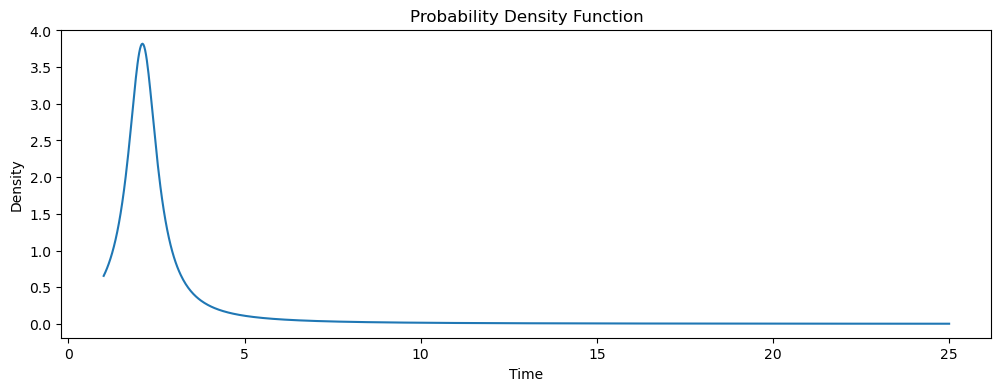

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
mu = 2.1
sigma = 0.5
height = 6
offset = -1

# Create time points
t = np.linspace(1, 25, 1000)

# Calculate PDF (derivative of CDF)
pdf = (height / (np.pi * sigma)) * (1 / (1 + ((t - mu)/sigma)**2))

# Plot PDF
plt.figure(figsize=(12, 4))
plt.plot(t, pdf)
plt.title('Probability Density Function')
plt.xlabel('Time')
plt.ylabel('Density')


Text(0.02, 0.98, 'Points shown: 10,000\nEntropy range: 0.000 to 5.963')

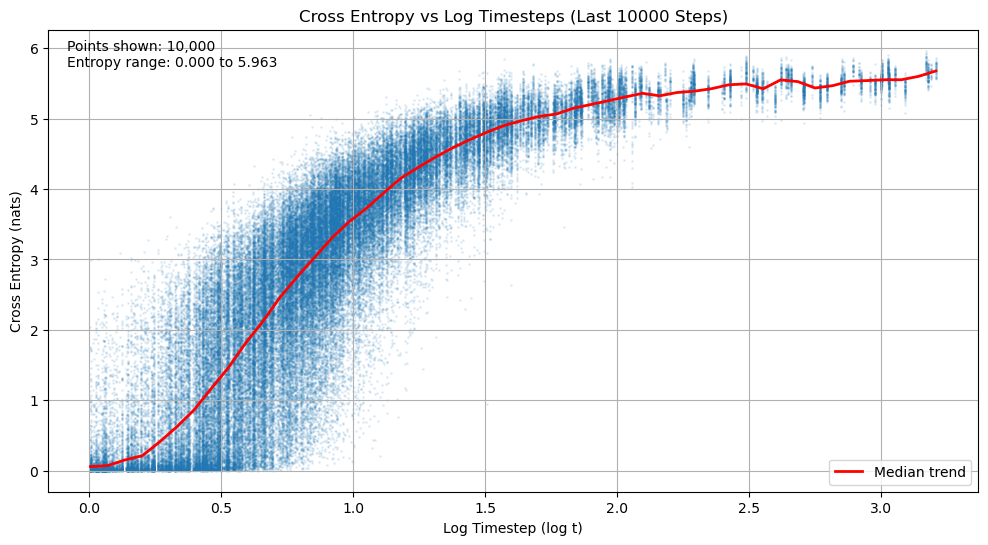

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Get last 10000 points
times = np.array(scheduler.times[-100_000:])
entropy = np.array(scheduler.entropy[-100_000:])

plt.figure(figsize=(12, 6))
plt.scatter(np.log(times), entropy, alpha=0.1, s=1)

# Trend line using log time bins
log_time_bins = np.linspace(np.log(times.min()), np.log(times.max()), 50)
entropy_means = [np.median(entropy[np.abs(np.log(times) - t) < (np.log(times.max())-np.log(times.min()))/50]) for t in log_time_bins]
plt.plot(log_time_bins, entropy_means, 'r-', linewidth=2, label='Median trend')

plt.title('Cross Entropy vs Log Timesteps (Last 10000 Steps)')
plt.xlabel('Log Timestep (log t)')
plt.ylabel('Cross Entropy (nats)')
plt.grid(True)
plt.legend()

plt.text(0.02, 0.98, f'Points shown: 10,000\nEntropy range: {entropy.min():.3f} to {entropy.max():.3f}', 
        transform=plt.gca().transAxes, verticalalignment='top')

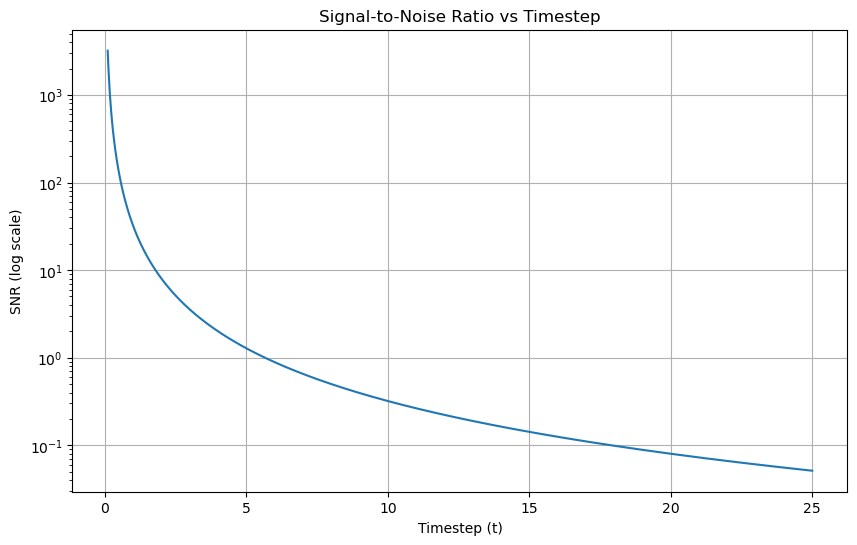

In [24]:
import numpy as np
import matplotlib.pyplot as plt

embed_dim = 32  # typical embedding dimension
t = np.linspace(0.1, 25, 1000)
snr = embed_dim/(t**2)

plt.figure(figsize=(10, 6))
plt.plot(t, snr)
plt.yscale('log')
plt.title('Signal-to-Noise Ratio vs Timestep')
plt.xlabel('Timestep (t)')
plt.ylabel('SNR (log scale)')
plt.grid(True)
plt.show()

In [16]:
def generate_sample(
    model,
    scheduler,
    batch_size=1,
    seq_len=10,
    n_steps=50,
    t_min=None,
    t_max=None,
    device="cuda"
):

    emb_dim = model.embedding.embedding_dim
    
    # Get timesteps as a 1D sequence
    timesteps = scheduler.make_timesteps(
        n_steps,
        tmin=t_min,
        tmax=t_max,
        device=device
    )
    
    # Initialize noise
    image = torch.randn(batch_size, seq_len, emb_dim, device=device) * timesteps[0]

    # Reset self-conditioning state
    model.self_conditioner.prev_preds = None
    p_embeddings = torch.zeros_like(image)

    for i in range(len(timesteps) - 1):
        with torch.no_grad():
            # Concatenate residual stream with conditioning
            x = torch.cat([image, p_embeddings], dim=-1)
            c_in = 1 / torch.sqrt(timesteps[i].unsqueeze(0)**2 + 1) #normalization factor
            x = x * c_in

            # Forward through model components
            x = model.input_proj(x)
            
            c_noise = torch.log(timesteps[i].unsqueeze(0)) / 4
            time_emb = model.time_embedding(c_noise)
            
            for block in model.transformer_blocks:
                x = block(x, time_emb)
            
            logits = model.output_proj(x)

        model.self_conditioner.update_prev_preds(logits)

        probs = torch.softmax(logits, dim=-1)
        # Get expected embeddings for next residual
        expected_embedding = torch.matmul(probs, model.embedding.normalized_embeddings)

        # Update conditioning for next step
        p_embeddings = model.self_conditioner.get_self_conditioning(
            x, model, timesteps[i+1], training=False
        )

        # # Compute derivative and update residual stream
        d = (image - expected_embedding) / timesteps[i] 
        dt = timesteps[i + 1] - timesteps[i]
        image = image + dt * d

        
        # d = (expected_embedding - image) / (timesteps[i]**2)
        # image = image - dt * d

    # Final forward pass
    with torch.no_grad():
        x = torch.cat([image, p_embeddings], dim=-1)
        x = model.input_proj(x)
        c_noise = torch.log(timesteps[-1].unsqueeze(0)) / 4
        time_emb = model.time_embedding(c_noise)

        for block in model.transformer_blocks:
            x = block(x, time_emb)
            
        final_logits = model.output_proj(x)

    predicted_tokens = torch.argmax(final_logits, dim=2)
    
    return predicted_tokens


def generate_unique_samples(
    model,
    scheduler,
    num_samples,
    lmin=5,
    lmax=10,
    n_steps=50,
    t_min=None,
    t_max=None,
    device="cuda"
):
    """
    Generate multiple samples with varying lengths and deduplicate tokens within each sequence.
    
    Args:
        model: The diffusion model
        scheduler: Timestep scheduler
        num_samples: Number of samples to generate
        lmin: Minimum sequence length
        lmax: Maximum sequence length
        n_steps: Number of diffusion steps
        t_min: Minimum timestep value
        t_max: Maximum timestep value
        device: Device to run generation on
        
    Returns:
        list[list[int]]: List of sequences, where each sequence contains unique tokens
    """
    unique_sequences = []
    
    for _ in range(num_samples):
        # Sample a random sequence length
        seq_len = torch.randint(low=lmin, high=lmax+1, size=(1,)).item()
        
        # Generate a single sample
        tokens = generate_sample(
            model,
            scheduler,
            batch_size=1,
            seq_len=seq_len,
            n_steps=n_steps,
            t_min=t_min,
            t_max=t_max,
            device=device
        )
        
        # Convert to list and get first sequence
        token_list = tokens[0].cpu().tolist()
        
        # Deduplicate while preserving order
        seen = set()
        unique_tokens = []
        for token in token_list:
            if token not in seen:
                seen.add(token)
                unique_tokens.append(token)
        
        unique_sequences.append(unique_tokens)
    
    return unique_sequences




In [17]:
tokens = generate_sample(
    model,
    scheduler,
    batch_size=3,
    seq_len=15,
    n_steps=50,
    t_min=1,
    t_max=25,
    device=device
)

AttributeError: 'simplifiedV2' object has no attribute 'embedding'

In [ ]:
sequences = generate_unique_samples(
    model,
    scheduler,
    num_samples=200,
    lmin=5,   # Minimum sequence length
    lmax=200,  # Maximum sequence length
    n_steps=50,
    t_min=1,
    t_max=25,
    device=device
)


/mnt/mnemo7/mpelus/miniconda3/envs/matlas/lib/python3.12/site-packages/sklearn/metrics/pairwise.py:2361: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/mnt/mnemo7/mpelus/miniconda3/envs/matlas/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


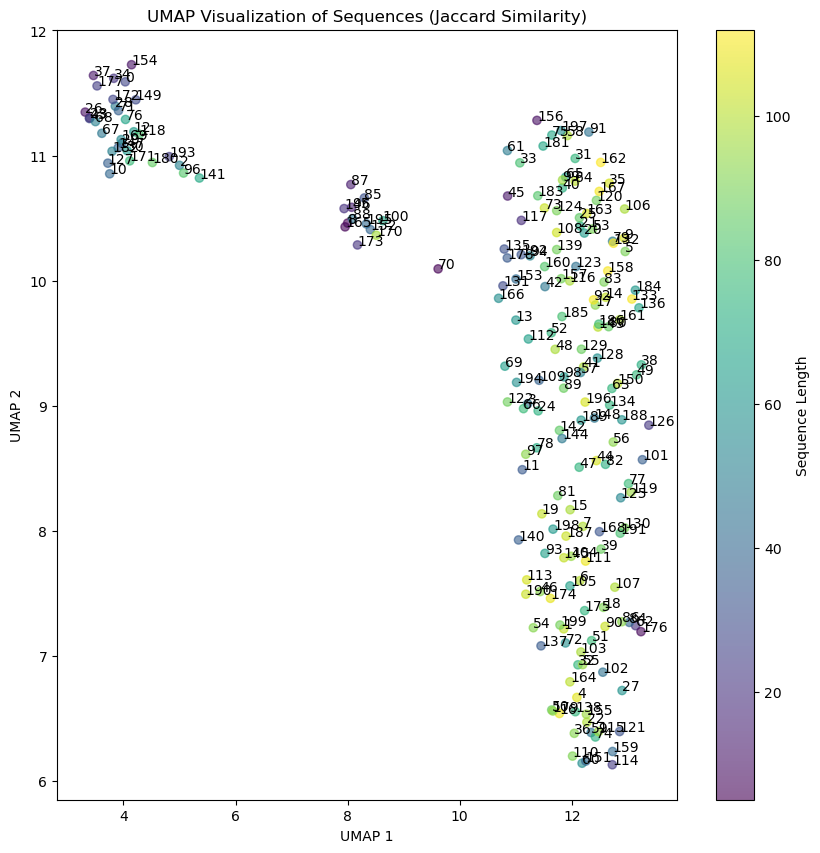

In [ ]:
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

# Binarize sequences
vocab_size = 519
binary_vecs = np.zeros((len(sequences), vocab_size))
for i, seq in enumerate(sequences):
    binary_vecs[i, seq] = 1

# Compute Jaccard distances
distances = pairwise_distances(binary_vecs, metric='jaccard')

# Apply UMAP
umap = UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric='precomputed'
)
embeddings = umap.fit_transform(distances)

# Create plot
plt.figure(figsize=(10, 10))
scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], 
                     c=[len(seq) for seq in sequences],
                     cmap='viridis',
                     alpha=0.6)

# Add sequence labels
for i, seq in enumerate(sequences):
    plt.annotate(f'{i}', (embeddings[i, 0], embeddings[i, 1]))

plt.colorbar(scatter, label='Sequence Length')
plt.title('UMAP Visualization of Sequences (Jaccard Similarity)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

tensor([34.9998, 24.1775, 18.7868, 15.5559, 13.4014, 11.8606, 10.7028,  9.8000,
         9.0757,  8.4810,  7.9834,  7.5605,  7.1963,  6.8790,  6.5997,  6.3518,
         6.1300,  5.9302,  5.7490,  5.5838,  5.4324,  5.2929,  5.1639,  5.0441,
         4.9325,  4.8280,  4.7299,  4.6376,  4.5504,  4.4679,  4.3896,  4.3150,
         4.2439,  4.1759,  4.1108,  4.0483,  3.9882,  3.9302,  3.8743,  3.8202,
         3.7678,  3.7170,  3.6676,  3.6195,  3.5726,  3.5268,  3.4820,  3.4382,
         3.3953,  3.3531,  3.3116,  3.2708,  3.2306,  3.1909,  3.1517,  3.1129,
         3.0745,  3.0364,  2.9986,  2.9610,  2.9236,  2.8863,  2.8491,  2.8119,
         2.7748,  2.7376,  2.7004,  2.6630,  2.6254,  2.5877,  2.5497,  2.5113,
         2.4726,  2.4335,  2.3940,  2.3539,  2.3133,  2.2720,  2.2300,  2.1873,
         2.1437,  2.0992,  2.0537,  2.0071,  1.9593,  1.9103,  1.8598,  1.8079,
         1.7542,  1.6988,  1.6414,  1.5819,  1.5200,  1.4556,  1.3884,  1.3182,
         1.2446,  1.1673,  1.0859,  1.00

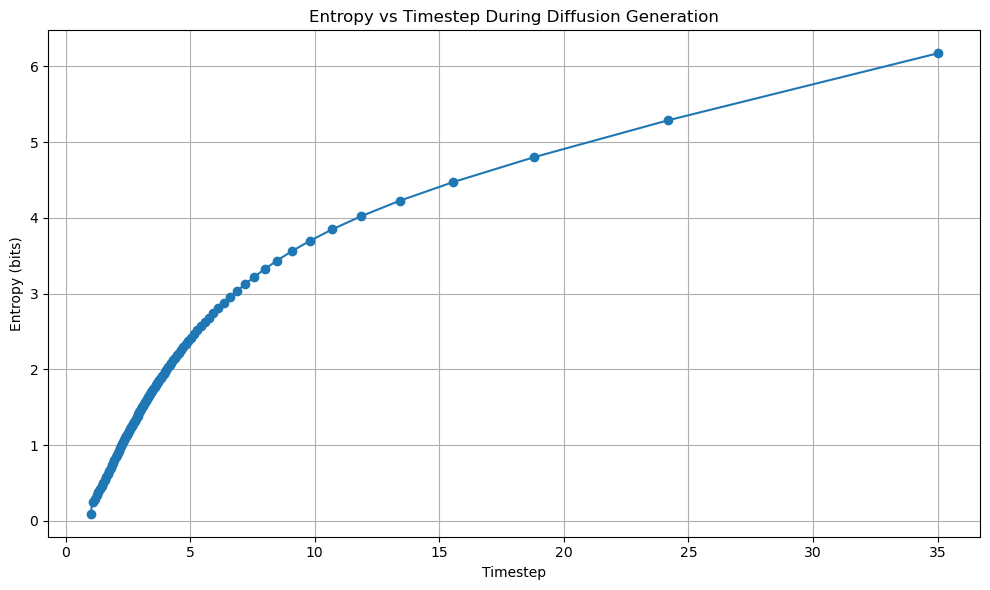

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_entropy_vs_timesteps(
    model,
    scheduler,
    batch_size=1,
    seq_len=10,
    n_steps=50,
    t_min=None,
    t_max=None,
    device="cuda"
):
    """
    Generate samples and plot entropy against timesteps.
    
    Args:
        model: The diffusion model
        scheduler: Timestep scheduler
        batch_size: Number of samples to generate in parallel
        seq_len: Length of each generated sequence
        n_steps: Number of diffusion steps
        t_min: Minimum timestep value
        t_max: Maximum timestep value
        device: Device to run generation on
    """
    emb_dim = model.embedding.embedding_dim
    
    # Get timesteps
    timesteps = scheduler.make_timesteps(
        n_steps,
        tmin=t_min,
        tmax=t_max,
        device=device
    )
    print(timesteps)
    
    # Initialize storage for entropy values
    entropy_values = []
    timestep_values = []
    
    # Initialize noise
    image = torch.randn(batch_size, seq_len, emb_dim, device=device) * timesteps[0]
    
    # Reset self-conditioning state
    model.self_conditioner.prev_preds = None
    p_embeddings = torch.zeros_like(image)

    def calculate_entropy(probs):
        """Calculate entropy from probability distribution"""
        # Add small epsilon to avoid log(0)
        eps = 1e-10
        entropy = -torch.sum(probs * torch.log2(probs + eps), dim=-1)
        return entropy.mean().item()

    for i in range(len(timesteps) - 1):
        with torch.no_grad():
            x = torch.cat([image, p_embeddings], dim=-1)
            c_in = 1 / torch.sqrt(timesteps[i].unsqueeze(0)**2 + 1)
            x = x * c_in

            x = model.input_proj(x)
            
            c_noise = torch.log(timesteps[i].unsqueeze(0)) / 4
            time_emb = model.time_embedding(c_noise)
            
            for block in model.transformer_blocks:
                x = block(x, time_emb)
            
            logits = model.output_proj(x)

        model.self_conditioner.update_prev_preds(logits)
        
        # Calculate probabilities and entropy
        probs = torch.softmax(logits, dim=-1)
        entropy = calculate_entropy(probs)
        
        # Store values for plotting
        entropy_values.append(entropy)
        timestep_values.append(timesteps[i].item())

        # Get expected embeddings for next residual
        expected_embedding = torch.matmul(probs, model.embedding.normalized_embeddings)
        
        p_embeddings = model.self_conditioner.get_self_conditioning(
            x, model, timesteps[i+1], training=False
        )

        d = (image - expected_embedding) / timesteps[i]**2
        dt = timesteps[i + 1] - timesteps[i]
        image = image + dt * d

    # Calculate final entropy
    with torch.no_grad():
        x = torch.cat([image, p_embeddings], dim=-1)
        x = model.input_proj(x)
        c_noise = torch.log(timesteps[-1].unsqueeze(0)) / 4
        time_emb = model.time_embedding(c_noise)

        for block in model.transformer_blocks:
            x = block(x, time_emb)
            
        final_logits = model.output_proj(x)
        final_probs = torch.softmax(final_logits, dim=-1)
        final_entropy = calculate_entropy(final_probs)

    entropy_values.append(final_entropy)
    timestep_values.append(timesteps[-1].item())

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(timestep_values, entropy_values, '-o')
    plt.xlabel('Timestep')
    plt.ylabel('Entropy (bits)')
    plt.title('Entropy vs Timestep During Diffusion Generation')
    plt.grid(True)
    
    
    plt.tight_layout()
    plt.show()
    
    return entropy_values, timestep_values

entropy_values, timestep_values = plot_entropy_vs_timesteps(
    model,
    scheduler,
    batch_size=1,
    seq_len=200,
    n_steps=100
)
